# Project 1

## (Subject)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import locale
import math
from countries import countries as c_list
import statsmodels.api as sm
%matplotlib widget

## Helper functions

In [2]:
def myImport(target):
    out = pd.read_csv(target, skiprows = [0], encoding="ISO-8859-1")
    return out

In [3]:
# Make it easier to filter data
def importDataFrame(df, series, name):
    global all_df
    
    # Build a drop list
    droplist = [var for var in df.columns if var not in ["Unnamed: 1", "Region/Country/Area", "Year", "Value"]]
    
    # Read in data, changing column names and keeping only desired data
    new = df.loc[df["Series"] == f"{series}"]\
        .drop(columns=droplist)\
        .rename(columns={"Unnamed: 1": "Place",
                         "Value": f"{name}"})\
        .set_index("Place", drop=True)\
        .loc[c_list]\
        .dropna()
    
    # Value read in is expected to be numeric.  Process as needed to return numeric
    new[f"{name}"] = new[f"{name}"]\
        .transform(lambda x: x.replace(',', ''))\
        .apply(float)    
    
    if "all_df" not in globals():
        all_df = new
    elif f"{name}" not in all_df.columns.to_list():
        left = all_df.reset_index()
        right = new.reset_index()
        
        all_df = pd.merge(left, right, on=["Place", "Region/Country/Area", "Year"], how="outer").set_index("Place")
    
    return new

In [4]:
# Get top and bottom in category
def getTopAndBottom(value, df=None, num=5, year=2015):
    if df == None and "all_df" in globals():
        df = all_df
    
    top = df.loc[df["Year"] == year]\
        .sort_values(f"{value}")\
        .tail(num)\
        .index\
        .to_list()

    bottom = df.loc[df["Year"] == year]\
        .sort_values(f"{value}")\
        .head(num)\
        .index\
        .to_list()
    
    return (top, bottom)

In [5]:
# Get bounds for plot.  Use off to apply an offset for graphing purposes
def getBounds(value, df=None, off=0.05):
    if df == None and "all_df" in globals():
        df = all_df
        
    minval = df[pd.notnull(df[f"{value}"])].sort_values(f"{value}").iloc[0][f"{value}"]
    maxval = df[pd.notnull(df[f"{value}"])].sort_values(f"{value}").iloc[-1][f"{value}"]
    
    off_minval = minval - (maxval - minval) * off
    off_maxval = maxval + (maxval - minval) * off
    
    return (off_minval, off_maxval)

In [38]:
def myMixed(value1, label1, value2, label2, title, saveas, 
            df1=None, df2=None, off_pct1=0.05, off_pct2=0.05,
            years=["2005", "2010", "2015"], colors=["red", "green", "blue"],
            scatterSize=25):
    
    if df1 == None and "all_df" in globals():
        df1 = all_df
    
    if df2 == None and "all_df" in globals():
        df2 = all_df
        
    # Parameters denoted with a 1 correspond to x-axis; 2 represents y-axis
        
    # Initialize graph
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    ax.grid()
    
    # Get axis limits
    x_lims = getBounds(f"{value1}")
    y_lims = getBounds(f"{value2}")
    
    ax.set_xlim((x_lims[0], x_lims[1]))
    ax.set_ylim((y_lims[0], y_lims[1]))
    
    ax.set_xlabel(f"{label1}", fontsize=18)
    ax.set_ylabel(f"{label2}", fontsize=18)
    ax.set_title(f"{title}", fontsize=25)
    ax.tick_params(labelsize=14)
    
    # Return rows with non-missing values
    x_nonmiss = df1[pd.notnull(df1[f"{value1}"])] 
    y_nonmiss = df2[pd.notnull(df2[f"{value2}"])] 
    
    for index, year in enumerate(years):
        color = colors[index]
        
        # Return rows from the correct year
        x_yearlist = [(int(value) == int(year)) for value in x_nonmiss["Year"]]
        y_yearlist = [(int(value) == int(year)) for value in y_nonmiss["Year"]]
        
        # Subset df above, leaving non-missing value rows of correct year
        x_vals = x_nonmiss[x_yearlist]
        y_vals = y_nonmiss[y_yearlist]
        
        # Create temporary dataset to create displays
        x_reduce = pd.merge(df1[["Region/Country/Area", "Year", "Total Population (Group)"]],  
                            x_vals[["Region/Country/Area", "Year", f"{value1}"]],
                            on=["Region/Country/Area", "Year"], 
                            how="inner")
        y_reduce = pd.merge(df2[["Region/Country/Area", "Year"]],
                            y_vals[["Region/Country/Area", "Year", f"{value2}"]],
                            on=["Region/Country/Area", "Year"],
                            how="inner")
        xy = pd.merge(x_reduce, y_reduce, on=["Region/Country/Area", "Year"], how="inner")
        
        # Run regression and get results
        model = sm.OLS(xy[f"{value2}"], xy[f"{value1}"])
        beta = model.fit().params.values[0]
        
        # Plots
        ax.scatter(xy[f"{value1}"],
                   xy[f"{value2}"],
                   s = xy["Total Population (Group)"] * scatterSize,
                   c = color,
                   alpha = 0.5,
                   marker = "o",
                   label=f"{str(year)}")
        
        ax.plot([x_lims[0], x_lims[1]],
                 [beta * x_lims[0], beta * x_lims[1]],
                 color = color
                )
        
    ax.legend(fontsize=12)

    plt.savefig(f"{saveas}.png")
    
    return fig, ax


## Pull in all data

In [26]:
# Read in raw data
LE_df = myImport("Data/SYB60_T03_Population Growth_Fertility_and_Mortality_Indicators.csv")
GDP_df = myImport("Data/SYB62_T13_201904_GDP_and_GDP_Per_Capita.csv")
POP_df = myImport("Data/SYB61_T02_Population_Surface_Area_and_Density.csv")
POPg_df = myImport("Data/SYB61_T03_Population_Growth_Rates_in_Urban_areas_and_Capital_cities.csv")
NRG_df = myImport( "Data/SYB62_T23_201904_Production_Trade_and_Supply_of_Energy.csv")

# Build master df for desired variables
LE_filtered_df = importDataFrame(LE_df, "Life expectancy at birth for both sexes (years)", "Life Expectancy")
GDP_filtered_df = importDataFrame(GDP_df, "GDP per capita (US dollars)", "GDP")
POP_filtered_df = importDataFrame(POP_df, "Population mid-year estimates (millions)", "Total Population")
POPg_filtered_df = importDataFrame(POPg_df, "Urban population (percent)", "Urban Population")
NRG_filtered_df = importDataFrame(NRG_df, "Primary energy production (petajoules)", "Energy Production")
TFR_filtered_df = importDataFrame(LE_df, "Total fertility rate (children per women)", "Total Fertility Rate")

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


## Other derived values of interest

In [32]:
all_df["Log GDP"] = all_df["GDP"].apply(math.log)

def myLog(num):
    try:
        lognum = math.log(num)
    except ValueError:
        lognum = None
    
    return lognum
        
all_df["Log Energy Production"] = all_df["Energy Production"].apply(myLog)
all_df["Log TFR"] = all_df["Total Fertility Rate"].apply(myLog)

def popGrade(pop):
    try:
        n_pop = float(pop)
    except ValueError:
        return None
    
    if 0 <= n_pop < 1:
        return 1
    elif 1 <= n_pop < 3:
        return 2
    elif 3 <= n_pop < 10:
        return 3
    elif 10 <= n_pop < 25:
        return 4
    else:
        return 5
    
all_df["Total Population (Group)"] = all_df["Total Population"].apply(popGrade)

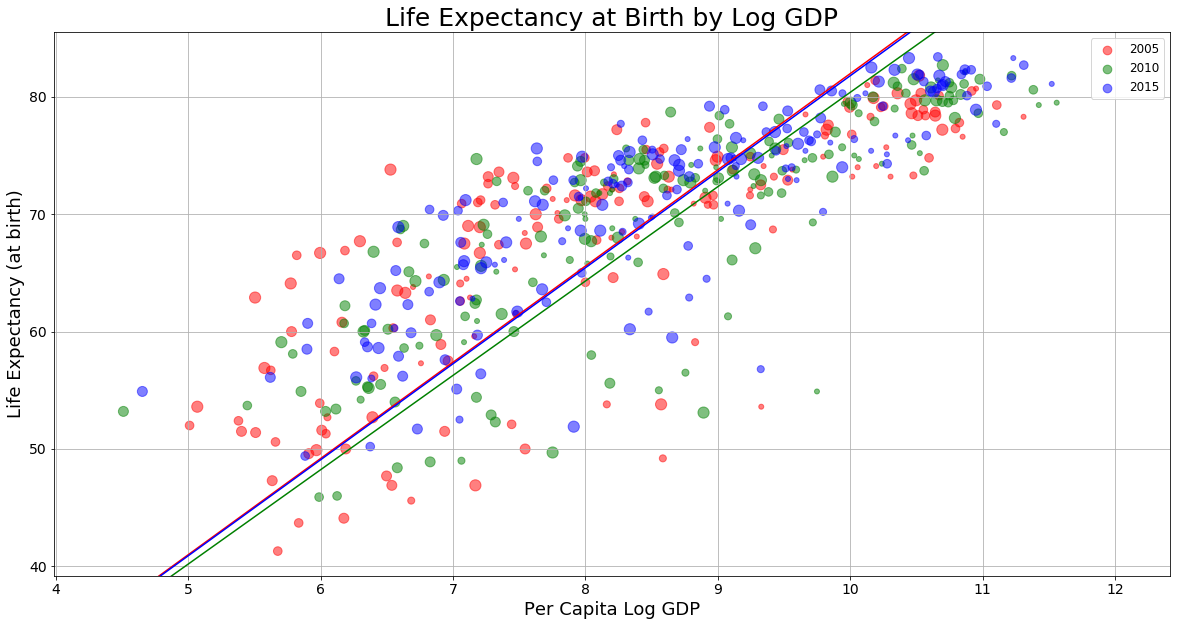

In [39]:
myfig, myax = myMixed("Log GDP", 
                      "Per Capita Log GDP",
                      "Life Expectancy",
                      "Life Expectancy (at birth)",
                      "Life Expectancy at Birth by Log GDP",
                      "GDP_LE")

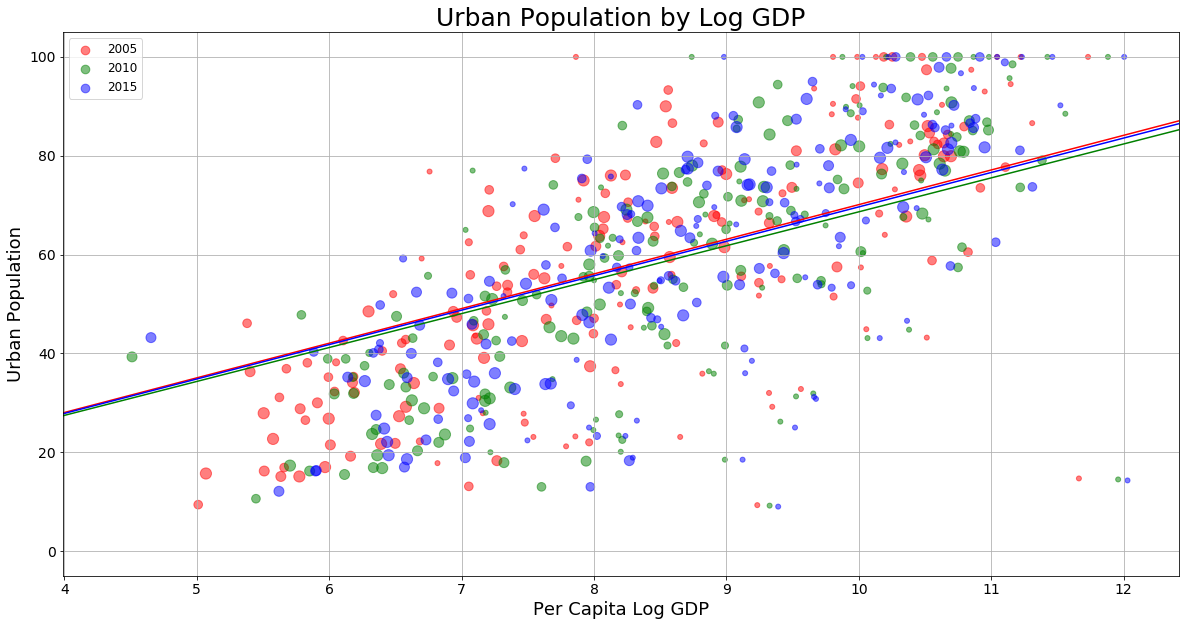

In [35]:
myfig, myax = myMixed("Log GDP", 
                      "Per Capita Log GDP",
                      "Urban Population",
                      "Urban Population",
                      "Urban Population by Log GDP",
                      "UP_GDP")

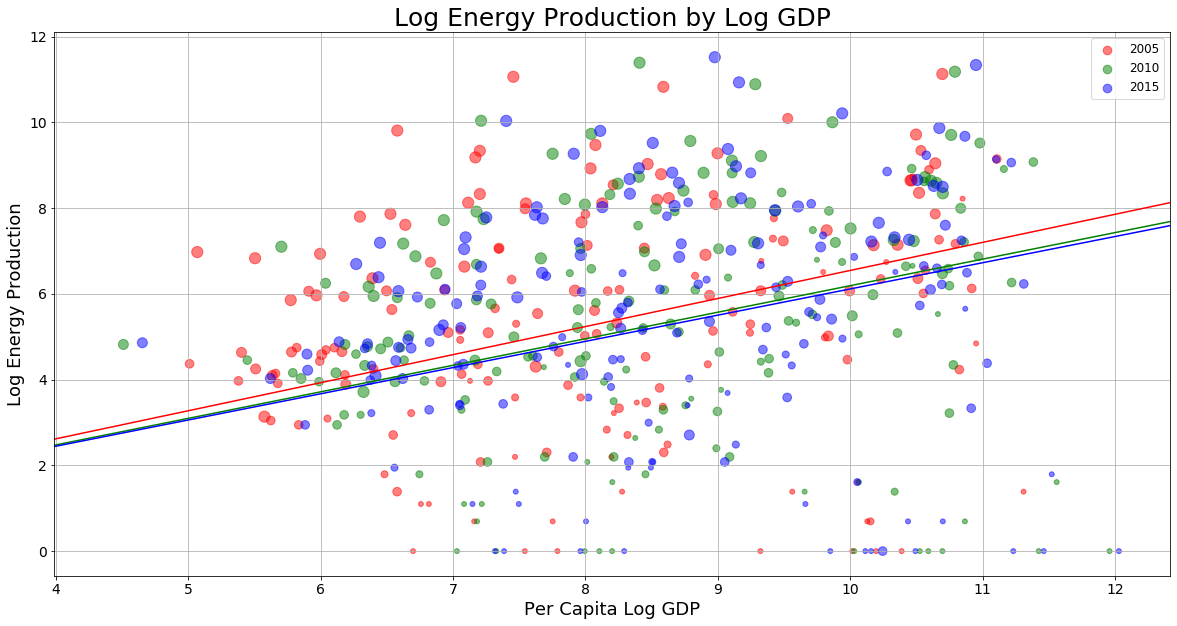

In [36]:
myfig, myax = myMixed("Log GDP", 
                      "Per Capita Log GDP",
                      "Log Energy Production",
                      "Log Energy Production",
                      "Log Energy Production by Log GDP",
                      "EP_GDP")

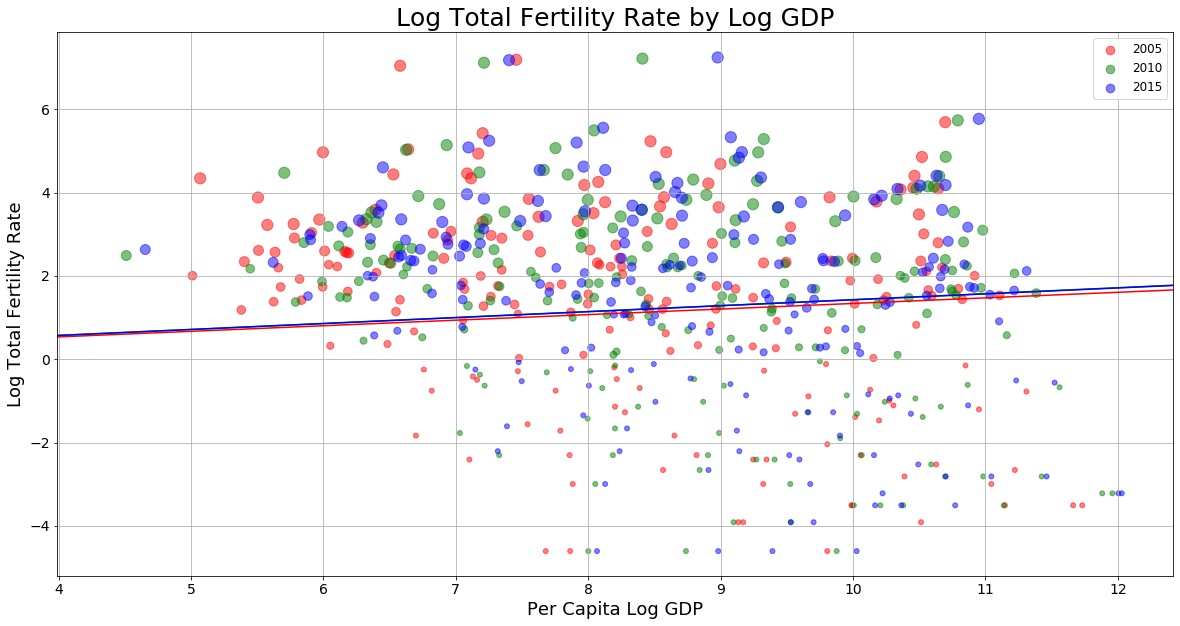

In [37]:
myfig, myax = myMixed("Log GDP", 
                      "Per Capita Log GDP",
                      "Log TFR",
                      "Log Total Fertility Rate",
                      "Log Total Fertility Rate by Log GDP",
                      "TFR_GDP")

In [14]:
#LE_df = myImport("Data/SYB60_T03_Population Growth_Fertility_and_Mortality_Indicators.csv")
#GDP_df = myImport("Data/SYB62_T13_201904_GDP_and_GDP_Per_Capita.csv")
#POP_df = myImport("Data/SYB61_T02_Population_Surface_Area_and_Density.csv")
#POPg_df = myImport("Data/SYB61_T03_Population_Growth_Rates_in_Urban_areas_and_Capital_cities.csv")
#NRG_df = myImport( "Data/SYB62_T23_201904_Production_Trade_and_Supply_of_Energy.csv")

LE_df["Series"].unique()

array(['Population annual rate of increase (percent)',
       'Total fertility rate (children per women)',
       'Infant mortality for both sexes (per 1,000 live births)',
       'Maternal mortality ratio (deaths per 100,000 population)',
       'Life expectancy at birth for both sexes (years)',
       'Life expectancy at birth for males (years)',
       'Life expectancy at birth for females (years)'], dtype=object)